In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
    accuracy_score,
)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
df = pd.read_csv(
    "/home/artemiy/rink_master/rink_master_data/data_wencoded_teams47k.csv"
)

In [4]:
df.head()

,Unnamed: 0,gameID,gameDate,Team,Opponent,homeRoad,gamesPlayed,Win,Loss,Tie,OTLoss,points,pointPct,regulationWins,regulationAndOtWins,shootoutWins,goalsFor,goalsAgainst,goalsForPerGame,goalsAgainstPerGame,powerPlayPct,penaltyKillPct,powerPlayNetPct,penaltyKillNetPct,shotsForPerGame,shotsAgainstPerGame,faceoffWinPct,Year,Month,Season,Weights,Result,NonRegulationTime
0,1,2003020003,2003-10-08,28,15,1,1,0,1,0,0,0,0.0,0,0,0,0,1,0.0,1.0,0.00,1.00,0.00,1.000000,33.0,22.0,0.57,2003,10,2003-2004,0.0,0,False
1,2,2003020002,2003-10-08,24,23,0,1,1,0,0,0,2,1.0,1,1,0,4,1,4.0,1.0,0.33,0.75,0.33,0.750000,22.0,21.0,0.53,2003,10,2003-2004,0.0,1,False
2,4,2003020003,2003-10-08,15,28,0,1,1,0,0,0,2,1.0,1,1,0,1,0,1.0,0.0,0.00,1.00,0.00,1.000000,22.0,33.0,0.43,2003,10,2003-2004,0.0,1,False
3,5,2003020002,2003-10-08,23,24,1,1,0,1,0,0,0,0.0,0,0,0,1,4,1.0,4.0,0.25,0.67,0.25,0.666666,21.0,22.0,0.47,2003,10,2003-2004,0.0,0,False
4,6,2003020011,2003-10-09,26,21,1,1,0,1,0,0,0,0.0,0,0,0,2,5,2.0,5.0,0.33,0.60,0.33,0.600000,21.0,28.0,0.50,2003,10,2003-2004,0.0,0,False


In [5]:
df.drop(
    ["Unnamed: 0", "NonRegulationTime"],
    axis=1,
    inplace=True,
)

In [6]:
# last_seasons = df["Season"].unique()[-5:]
# df = df[df["Season"].isin(last_seasons)].reset_index(drop=True)

In [7]:
df["gameNumber"] = df.groupby(["Team", "Season"]).cumcount() + 1
# df = df[df["gameNumber"] > 10]

In [8]:
non_zero_counts = {
    "Tie": df["Tie"].astype(bool).sum(),
    "OTLoss": df["OTLoss"].astype(bool).sum(),
    "regulationWins": df["regulationWins"].astype(bool).sum(),
    "regulationAndOtWins": df["regulationAndOtWins"].astype(bool).sum(),
    "shootoutWins": df["shootoutWins"].astype(bool).sum(),
}

In [9]:
for column, count in non_zero_counts.items():
    print(f"{column}: {count} ненулевых значений")

Tie: 0 ненулевых значений
OTLoss: 5371 ненулевых значений
regulationWins: 18364 ненулевых значений
regulationAndOtWins: 21329 ненулевых значений
shootoutWins: 2409 ненулевых значений


In [10]:
df = df.drop(columns=["Tie", 'Loss', 'Win'])

In [11]:
df = df.sort_values(by="gameDate")

In [12]:
def calculate_streaks(df):
    df = df.sort_values(by="gameDate")

    # Вычисляем скользящее количество побед и поражений за последние 5 матчей
    df["rolling_Win"] = (
        df["Result"].rolling(window=5, min_periods=1, closed="left").sum()
    )
    df["rolling_Loss"] = (
        (1 - df["Result"]).rolling(window=5, min_periods=1, closed="left").sum()
    )

    # Обновляем значения, чтобы последний матч не учитывался
    df["streak_Win"] = df["rolling_Win"].shift(1)
    df["streak_Loss"] = df["rolling_Loss"].shift(1)

    # Удаляем строки с NaN значениями (последний матч)
    df = df.dropna()

    return df

In [13]:
df = df.groupby("Team", group_keys=False).apply(calculate_streaks)

/tmp/ipykernel_464256/1167559267.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Team", group_keys=False).apply(calculate_streaks)


In [14]:
df.head()

,gameID,gameDate,Team,Opponent,homeRoad,gamesPlayed,OTLoss,points,pointPct,regulationWins,regulationAndOtWins,shootoutWins,goalsFor,goalsAgainst,goalsForPerGame,goalsAgainstPerGame,powerPlayPct,penaltyKillPct,powerPlayNetPct,penaltyKillNetPct,shotsForPerGame,shotsAgainstPerGame,faceoffWinPct,Year,Month,Season,Weights,Result,gameNumber,rolling_Win,rolling_Loss,streak_Win,streak_Loss
148,2003020082,2003-10-22,1,12,0,1,0,0,0.0,0,0,0,1,2,1.0,2.0,0.00,1.0,0.00,1.00,33.0,23.0,0.55,2003,10,2003-2004,0.0,0,3,1.0,1.0,1.0,0.0
174,2003020097,2003-10-24,1,5,1,1,0,2,1.0,1,1,0,2,1,2.0,1.0,0.00,1.0,0.00,1.00,34.0,18.0,0.49,2003,10,2003-2004,0.0,1,4,1.0,2.0,1.0,1.0
193,2003020109,2003-10-25,1,6,0,1,0,0,0.0,0,0,0,2,5,2.0,5.0,0.20,0.5,0.20,0.75,33.0,26.0,0.43,2003,10,2003-2004,0.0,0,5,2.0,2.0,1.0,2.0
216,2003020122,2003-10-28,1,2,1,1,0,2,1.0,1,1,0,4,0,4.0,0.0,0.00,1.0,0.00,1.00,27.0,25.0,0.48,2003,10,2003-2004,0.0,1,6,2.0,3.0,2.0,2.0
247,2003020139,2003-10-30,1,4,0,1,0,2,1.0,1,1,0,3,2,3.0,2.0,0.14,1.0,0.14,1.00,28.0,16.0,0.45,2003,10,2003-2004,0.0,1,7,2.0,3.0,2.0,3.0


In [15]:
def rolling_features(group):
    group = group.sort_values(by="gameDate")

    # Скользящее среднее по количеству заброшенных и пропущенных голов
    group["rolling_goalsFor"] = (
        group["goalsFor"].rolling(window=5, min_periods=1, closed="left").mean()
    )
    group["rolling_goalsAgainst"] = (
        group["goalsAgainst"].rolling(window=5, min_periods=1, closed="left").mean()
    )

    # Скользящее по % реализации бросков
    group["rolling_shotGoalsPct"] = (
        (group["goalsFor"] / group["shotsForPerGame"])
        .rolling(window=5, min_periods=1, closed="left")
        .mean()
    )

    # Скользящее по % сейвов
    group["rolling_savePct"] = (
        (
            (group["shotsAgainstPerGame"] - group["goalsAgainst"])
            / group["shotsAgainstPerGame"].replace(0, np.nan)
        )
        .rolling(window=5, min_periods=1, closed="left")
        .mean()
    )

    # Скользящее среднее по победам и поражениям
    group["rolling_Win"] = (
        group["Result"].rolling(window=5, min_periods=1, closed="left").mean()
    )
    group["rolling_Loss"] = (
        (1 - group["Result"]).rolling(window=5, min_periods=1, closed="left").mean()
    )

    # Скользящее среднее по проценту реализации большинства и меньшинства
    group["rolling_powerPlayPct"] = (
        group["powerPlayPct"].rolling(window=5, min_periods=1, closed="left").mean()
    )
    group["rolling_penaltyKillPct"] = (
        group["penaltyKillPct"].rolling(window=5, min_periods=1, closed="left").mean()
    )

    # Скользящее по нанесенным броскам и полученным броскам
    group["rolling_shotsFor"] = (
        group["shotsForPerGame"].rolling(window=5, min_periods=1, closed="left").mean()
    )
    group["rolling_shotsAgainst"] = (
        group["shotsAgainstPerGame"]
        .rolling(window=5, min_periods=1, closed="left")
        .mean()
    )

    # Эффективность большинства и меньшинства
    group["rolling_powerPlayNetPct"] = (
        group["powerPlayNetPct"].rolling(window=5, min_periods=1, closed="left").mean()
    )
    group["rolling_penaltyKillNetPct"] = (
        group["penaltyKillNetPct"]
        .rolling(window=5, min_periods=1, closed="left")
        .mean()
    )

    # Скользящее по количеству побед в домашних и гостевых матчах
    group["rolling_homeWin"] = (
        group[group["homeRoad"] == 1]["Result"]
        .rolling(window=5, min_periods=1, closed="left")
        .mean()
    )
    group["rolling_roadWin"] = (
        group[group["homeRoad"] == 0]["Result"]
        .rolling(window=5, min_periods=1, closed="left")
        .mean()
    )

    # Заполнение NaN с использованием предыдущих значений
    group["rolling_homeWin"] = group["rolling_homeWin"].fillna(0)
    group["rolling_roadWin"] = group["rolling_roadWin"].fillna(0)

    # Округление выбранных столбцов до 2 знаков после запятой
    columns_to_round = [
        "powerPlayPct",
        "powerPlayNetPct",
        "penaltyKillPct",
        "penaltyKillNetPct",
        "rolling_goalsFor",
        "rolling_goalsAgainst",
        "rolling_shotGoalsPct",
        "rolling_savePct",
        "rolling_Win",
        "rolling_Loss",
        "rolling_powerPlayPct",
        "rolling_penaltyKillPct",
        "rolling_shotsFor",
        "rolling_shotsAgainst",
        "rolling_powerPlayNetPct",
        "rolling_penaltyKillNetPct",
        "rolling_homeWin",
        "rolling_roadWin",
    ]
    group[columns_to_round] = group[columns_to_round].round(2)
    group = group.dropna()

    return group

In [16]:
# проверка на дубли
def find_duplicate_columns(df):
    duplicate_columns = []
    columns = df.columns

    for i, col1 in enumerate(columns):
        for col2 in columns[i + 1 :]:
            if df[col1].equals(df[col2]):
                duplicate_columns.append((col1, col2))

    return duplicate_columns


duplicates = find_duplicate_columns(df)
print(f"Duplicate columns: {duplicates}")

Duplicate columns: []


In [17]:
df.head()

,gameID,gameDate,Team,Opponent,homeRoad,gamesPlayed,OTLoss,points,pointPct,regulationWins,regulationAndOtWins,shootoutWins,goalsFor,goalsAgainst,goalsForPerGame,goalsAgainstPerGame,powerPlayPct,penaltyKillPct,powerPlayNetPct,penaltyKillNetPct,shotsForPerGame,shotsAgainstPerGame,faceoffWinPct,Year,Month,Season,Weights,Result,gameNumber,rolling_Win,rolling_Loss,streak_Win,streak_Loss
148,2003020082,2003-10-22,1,12,0,1,0,0,0.0,0,0,0,1,2,1.0,2.0,0.00,1.0,0.00,1.00,33.0,23.0,0.55,2003,10,2003-2004,0.0,0,3,1.0,1.0,1.0,0.0
174,2003020097,2003-10-24,1,5,1,1,0,2,1.0,1,1,0,2,1,2.0,1.0,0.00,1.0,0.00,1.00,34.0,18.0,0.49,2003,10,2003-2004,0.0,1,4,1.0,2.0,1.0,1.0
193,2003020109,2003-10-25,1,6,0,1,0,0,0.0,0,0,0,2,5,2.0,5.0,0.20,0.5,0.20,0.75,33.0,26.0,0.43,2003,10,2003-2004,0.0,0,5,2.0,2.0,1.0,2.0
216,2003020122,2003-10-28,1,2,1,1,0,2,1.0,1,1,0,4,0,4.0,0.0,0.00,1.0,0.00,1.00,27.0,25.0,0.48,2003,10,2003-2004,0.0,1,6,2.0,3.0,2.0,2.0
247,2003020139,2003-10-30,1,4,0,1,0,2,1.0,1,1,0,3,2,3.0,2.0,0.14,1.0,0.14,1.00,28.0,16.0,0.45,2003,10,2003-2004,0.0,1,7,2.0,3.0,2.0,3.0


In [18]:
df = df.reset_index(drop=True)
df = df.groupby("Team", group_keys=False).apply(rolling_features)

/tmp/ipykernel_464256/782063967.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Team", group_keys=False).apply(rolling_features)


In [19]:
# df = df.fillna(0)

In [20]:
df.isna().sum()

gameID                       0
gameDate                     0
Team                         0
Opponent                     0
homeRoad                     0
gamesPlayed                  0
OTLoss                       0
points                       0
pointPct                     0
regulationWins               0
regulationAndOtWins          0
shootoutWins                 0
goalsFor                     0
goalsAgainst                 0
goalsForPerGame              0
goalsAgainstPerGame          0
powerPlayPct                 0
penaltyKillPct               0
powerPlayNetPct              0
penaltyKillNetPct            0
shotsForPerGame              0
shotsAgainstPerGame          0
faceoffWinPct                0
Year                         0
Month                        0
Season                       0
Weights                      0
Result                       0
gameNumber                   0
rolling_Win                  0
rolling_Loss                 0
streak_Win                   0
streak_L

In [21]:
df = df.drop(columns=["gamesPlayed"])

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47380 entries, 1 to 47411
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gameID                     47380 non-null  int64  
 1   gameDate                   47380 non-null  object 
 2   Team                       47380 non-null  int64  
 3   Opponent                   47380 non-null  int64  
 4   homeRoad                   47380 non-null  int64  
 5   OTLoss                     47380 non-null  int64  
 6   points                     47380 non-null  int64  
 7   pointPct                   47380 non-null  float64
 8   regulationWins             47380 non-null  int64  
 9   regulationAndOtWins        47380 non-null  int64  
 10  shootoutWins               47380 non-null  int64  
 11  goalsFor                   47380 non-null  int64  
 12  goalsAgainst               47380 non-null  int64  
 13  goalsForPerGame            47380 non-null  float64


In [23]:
train = df[df["gameDate"] < "2023-10-10"]
test = df[df["gameDate"] >= "2023-10-10"]

In [24]:
train.shape

(44756, 44)

In [25]:
test.shape

(2624, 44)

In [26]:
features = [
    "Team",
    "Opponent",
    "homeRoad",
    "Weights",
    "gameNumber",
    "streak_Win",
    "streak_Loss",
    "rolling_goalsFor",
    "rolling_goalsAgainst",
    "rolling_shotGoalsPct",
    "rolling_savePct",
    "rolling_powerPlayPct",
    "rolling_penaltyKillPct",
    "rolling_shotsFor",
    "rolling_shotsAgainst",
    "rolling_powerPlayNetPct",
    "rolling_penaltyKillNetPct",
    "rolling_homeWin",
    "rolling_roadWin",
]
target = "Result"

In [27]:
X_train = train[features]
y_train = train[target]

In [28]:
X_test = test[features]
y_test = test[target]

In [29]:
X_train

,Team,Opponent,homeRoad,Weights,gameNumber,streak_Win,streak_Loss,rolling_goalsFor,rolling_goalsAgainst,rolling_shotGoalsPct,rolling_savePct,rolling_powerPlayPct,rolling_penaltyKillPct,rolling_shotsFor,rolling_shotsAgainst,rolling_powerPlayNetPct,rolling_penaltyKillNetPct,rolling_homeWin,rolling_roadWin
1,1,5,1,0.000000,4,1.0,1.0,1.00,2.00,0.03,0.91,0.00,1.00,33.00,23.00,0.00,1.00,0.0,0.00
2,1,6,0,0.000000,5,1.0,2.0,1.50,1.50,0.04,0.93,0.00,1.00,33.50,20.50,0.00,1.00,0.0,0.00
3,1,2,1,0.000000,6,2.0,2.0,1.67,2.67,0.05,0.89,0.07,0.83,33.33,22.33,0.07,0.92,1.0,0.00
4,1,4,0,0.000000,7,2.0,3.0,2.25,2.00,0.07,0.92,0.05,0.88,31.75,23.00,0.05,0.94,0.0,0.00
5,1,20,0,0.000000,8,2.0,3.0,2.40,2.00,0.08,0.91,0.07,0.90,31.00,21.60,0.07,0.95,0.0,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47325,32,30,0,0.947368,78,3.0,2.0,3.80,2.40,0.12,0.88,0.31,0.93,32.20,19.40,0.31,1.04,0.0,0.40
47326,32,15,0,0.947368,79,3.0,2.0,4.40,1.80,0.14,0.91,0.31,1.00,31.60,21.20,0.31,1.11,0.0,0.60
47327,32,30,1,0.947368,80,4.0,1.0,5.00,2.20,0.16,0.90,0.27,0.93,30.00,23.20,0.27,1.04,0.6,0.00
47328,32,31,1,0.947368,81,4.0,1.0,5.60,1.80,0.18,0.93,0.27,0.93,32.20,24.00,0.27,1.04,0.6,0.00


In [30]:
X_test

,Team,Opponent,homeRoad,Weights,gameNumber,streak_Win,streak_Loss,rolling_goalsFor,rolling_goalsAgainst,rolling_shotGoalsPct,rolling_savePct,rolling_powerPlayPct,rolling_penaltyKillPct,rolling_shotsFor,rolling_shotsAgainst,rolling_powerPlayNetPct,rolling_penaltyKillNetPct,rolling_homeWin,rolling_roadWin
1471,1,16,0,1.0,1,3.0,2.0,5.0,2.0,0.15,0.93,0.28,0.80,33.4,29.8,0.28,0.84,0.0,1.0
1472,1,30,0,1.0,2,4.0,1.0,4.8,2.4,0.15,0.92,0.27,0.70,31.4,32.2,0.27,0.74,0.0,1.0
1473,1,12,0,1.0,3,4.0,1.0,3.8,2.8,0.12,0.92,0.21,0.64,31.4,35.4,0.21,0.64,0.0,0.8
1474,1,2,1,1.0,4,3.0,2.0,4.2,3.2,0.13,0.90,0.29,0.79,32.2,33.4,0.29,0.79,0.4,0.0
1475,1,8,1,1.0,5,3.0,2.0,4.0,3.6,0.12,0.89,0.45,0.79,34.0,32.2,0.45,0.79,0.6,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47407,32,26,0,1.0,78,3.0,2.0,2.8,2.2,0.10,0.92,0.16,0.73,24.8,27.8,0.16,0.73,0.0,0.6
47408,32,24,1,1.0,79,3.0,2.0,3.0,2.2,0.11,0.91,0.16,0.83,31.4,26.4,0.16,0.83,0.4,0.0
47409,32,18,1,1.0,80,3.0,2.0,2.4,2.4,0.09,0.91,0.16,0.87,30.4,27.2,0.16,0.87,0.4,0.0
47410,32,29,1,1.0,81,2.0,3.0,2.2,2.2,0.08,0.91,0.11,0.93,29.8,27.4,0.11,0.93,0.4,0.0


In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
lr = LogisticRegression(max_iter=1000, random_state=1)
lr.fit(X_train_scaled, y_train)
preds_lr = lr.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, preds_lr)
print(f"Точность предсказаний (Logistic Regression): {accuracy_lr * 100:.2f}%")

Точность предсказаний (Logistic Regression): 57.43%


In [33]:
preds_lr = lr.predict(X_test_scaled)
preds_lr_proba = lr.predict_proba(X_test_scaled)[:, 1]

In [34]:
accuracy_lr = accuracy_score(y_test, preds_lr)
precision_lr = precision_score(y_test, preds_lr)
recall_lr = recall_score(y_test, preds_lr)
f1_lr = f1_score(y_test, preds_lr)
roc_auc_lr = roc_auc_score(y_test, preds_lr_proba)
log_loss_lr = log_loss(y_test, preds_lr_proba)

In [35]:
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")
print(f"ROC AUC: {roc_auc_lr:.4f}")
print(f"Log Loss: {log_loss_lr:.4f}")

Accuracy: 0.5743
Precision: 0.5743
Recall: 0.5747
F1 Score: 0.5745
ROC AUC: 0.5926
Log Loss: 0.6796


In [36]:
print(y_test.value_counts())

Result
1    1312
0    1312
Name: count, dtype: int64


In [37]:
# Проверка на пересечение gameID в тренировочном и тестовом наборах
common_game_ids = set(train["gameID"]).intersection(set(test["gameID"]))
print(f"Common game IDs: {len(common_game_ids)}")

Common game IDs: 0


In [38]:
print(pd.Series(preds_lr_proba).describe())

count    2624.000000
mean        0.499506
std         0.071887
min         0.297082
25%         0.446815
50%         0.500030
75%         0.551736
max         0.681319
dtype: float64


In [39]:
rf = RandomForestClassifier(n_estimators=100, random_state=1, min_samples_split=10)
rf.fit(X_train_scaled, y_train, sample_weight=train["Weights"])
preds_rf = rf.predict(X_test_scaled)
preds_rf_proba = rf.predict_proba(X_test_scaled)[:, 1]

In [40]:
accuracy_rf = accuracy_score(y_test, preds_rf)
precision_rf = precision_score(y_test, preds_rf)
recall_rf = recall_score(y_test, preds_rf)
f1_rf = f1_score(y_test, preds_rf)
roc_auc_rf = roc_auc_score(y_test, preds_rf_proba)
log_loss_rf = log_loss(y_test, preds_rf_proba)

In [41]:
print(f"Точность предсказаний (Random Forest): {accuracy_rf * 100:.2f}%")
print(f"Precision: {precision_rf:.2f}")
print(f"Recall: {recall_rf:.2f}")
print(f"F1-Score: {f1_rf:.2f}")
print(f"ROC-AUC: {roc_auc_rf:.2f}")
print(f"Log-Loss: {log_loss_rf:.2f}")

Точность предсказаний (Random Forest): 55.11%
Precision: 0.55
Recall: 0.55
F1-Score: 0.55
ROC-AUC: 0.57
Log-Loss: 0.69


In [42]:
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [43]:
smote = SMOTE(random_state=1)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [44]:
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

In [45]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 5],
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=1), param_grid, cv=5, scoring="f1"
)
grid_search.fit(X_train_scaled, y_train_balanced)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 5],
                         'min_samples_split': [2, 10],
                         'n_estimators': [100, 200]},
             scoring='f1')

In [46]:
best_rf = grid_search.best_estimator_

In [47]:
preds_rf_best = best_rf.predict(X_test_scaled)
preds_rf_proba_best = best_rf.predict_proba(X_test_scaled)[:, 1]

In [48]:
accuracy_rf_best = accuracy_score(y_test, preds_rf_best)
precision_rf_best = precision_score(y_test, preds_rf_best)
recall_rf_best = recall_score(y_test, preds_rf_best)
f1_rf_best = f1_score(y_test, preds_rf_best)
roc_auc_rf_best = roc_auc_score(y_test, preds_rf_proba_best)
log_loss_rf_best = log_loss(y_test, preds_rf_proba_best)

In [49]:
print(f"Точность предсказаний (Random Forest с весами): {accuracy_rf_best * 100:.2f}%")
print(f"Precision: {precision_rf_best:.2f}")
print(f"Recall: {recall_rf_best:.2f}")
print(f"F1-Score: {f1_rf_best:.2f}")
print(f"ROC-AUC: {roc_auc_rf_best:.2f}")
print(f"Log-Loss: {log_loss_rf_best:.2f}")

Точность предсказаний (Random Forest с весами): 57.47%
Precision: 0.57
Recall: 0.59
F1-Score: 0.58
ROC-AUC: 0.59
Log-Loss: 0.68


In [50]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [51]:
xgb_model = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", random_state=1
)
xgb_model.fit(X_train_scaled, y_train_balanced)

/home/artemiy/rink_master/.rink_master/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:39:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [52]:
xgb_preds = xgb_model.predict(X_test_scaled)
xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

In [53]:
xgb_accuracy = accuracy_score(y_test, xgb_preds)
xgb_precision = precision_score(y_test, xgb_preds)
xgb_recall = recall_score(y_test, xgb_preds)
xgb_f1 = f1_score(y_test, xgb_preds)
xgb_roc_auc = roc_auc_score(y_test, xgb_proba)
xgb_log_loss = log_loss(y_test, xgb_proba)

In [54]:
print(f"Точность предсказаний (XGBoost): {xgb_accuracy * 100:.2f}%")
print(f"Precision: {xgb_precision:.2f}")
print(f"Recall: {xgb_recall:.2f}")
print(f"F1-Score: {xgb_f1:.2f}")
print(f"ROC-AUC: {xgb_roc_auc:.2f}")
print(f"Log-Loss: {xgb_log_loss:.2f}")

Точность предсказаний (XGBoost): 57.81%
Precision: 0.58
Recall: 0.57
F1-Score: 0.57
ROC-AUC: 0.60
Log-Loss: 0.69


In [55]:
X_train_scaled, y_train_balanced

(array([[-1.67432468, -1.21867158,  1.0003128 , ...,  1.37621554,
         -0.80711735, -0.85426213],
        [-1.67432468, -1.1048726 , -0.9996873 , ...,  1.37621554,
         -0.80711735, -0.85426213],
        [-1.67432468, -1.56006852,  1.0003128 , ...,  0.74628329,
          2.75056118, -0.85426213],
        ...,
        [ 1.51212826, -0.99107361, -0.9996873 , ...,  0.12151952,
         -0.80711735,  0.39879697],
        [ 0.60171313,  0.03311722,  1.0003128 , ...,  0.55086603,
          1.1035122 , -0.85426213],
        [-1.10531523, -0.08068176, -0.9996873 , ..., -0.35785102,
         -0.80711735,  1.89409948]]),
 0        1
 1        0
 2        1
 3        1
 4        1
         ..
 44759    1
 44760    1
 44761    1
 44762    1
 44763    1
 Name: Result, Length: 44764, dtype: int64)

In [56]:
cat_model = CatBoostClassifier(verbose=0, random_state=1)
cat_model.fit(X_train_scaled, y_train_balanced)

In [57]:
cat_preds = cat_model.predict(X_test_scaled)
cat_proba = cat_model.predict_proba(X_test_scaled)

In [58]:
cat_accuracy = accuracy_score(y_test, cat_preds)
cat_precision = precision_score(y_test, cat_preds)
cat_recall = recall_score(y_test, cat_preds)
cat_f1 = f1_score(y_test, cat_preds)
cat_roc_auc = roc_auc_score(y_test, cat_proba[:, 1])
cat_log_loss = log_loss(y_test, cat_proba)

In [59]:
print(f"Точность предсказаний (CatBoost): {cat_accuracy * 100:.2f}%")
print(f"Precision: {cat_precision:.2f}")
print(f"Recall: {cat_recall:.2f}")
print(f"F1-Score: {cat_f1:.2f}")
print(f"ROC-AUC: {cat_roc_auc:.2f}")
print(f"Log-Loss: {cat_log_loss:.2f}")

Точность предсказаний (CatBoost): 57.01%
Precision: 0.57
Recall: 0.57
F1-Score: 0.57
ROC-AUC: 0.60
Log-Loss: 0.68


In [60]:
df.head()

,gameID,gameDate,Team,Opponent,homeRoad,OTLoss,points,pointPct,regulationWins,regulationAndOtWins,shootoutWins,goalsFor,goalsAgainst,goalsForPerGame,goalsAgainstPerGame,powerPlayPct,penaltyKillPct,powerPlayNetPct,penaltyKillNetPct,shotsForPerGame,shotsAgainstPerGame,faceoffWinPct,Year,Month,Season,Weights,Result,gameNumber,rolling_Win,rolling_Loss,streak_Win,streak_Loss,rolling_goalsFor,rolling_goalsAgainst,rolling_shotGoalsPct,rolling_savePct,rolling_powerPlayPct,rolling_penaltyKillPct,rolling_shotsFor,rolling_shotsAgainst,rolling_powerPlayNetPct,rolling_penaltyKillNetPct,rolling_homeWin,rolling_roadWin
1,2003020097,2003-10-24,1,5,1,0,2,1.0,1,1,0,2,1,2.0,1.0,0.00,1.00,0.00,1.00,34.0,18.0,0.49,2003,10,2003-2004,0.0,1,4,0.00,1.00,1.0,1.0,1.00,2.00,0.03,0.91,0.00,1.00,33.00,23.00,0.00,1.00,0.0,0.00
2,2003020109,2003-10-25,1,6,0,0,0,0.0,0,0,0,2,5,2.0,5.0,0.20,0.50,0.20,0.75,33.0,26.0,0.43,2003,10,2003-2004,0.0,0,5,0.50,0.50,1.0,2.0,1.50,1.50,0.04,0.93,0.00,1.00,33.50,20.50,0.00,1.00,0.0,0.00
3,2003020122,2003-10-28,1,2,1,0,2,1.0,1,1,0,4,0,4.0,0.0,0.00,1.00,0.00,1.00,27.0,25.0,0.48,2003,10,2003-2004,0.0,1,6,0.33,0.67,2.0,2.0,1.67,2.67,0.05,0.89,0.07,0.83,33.33,22.33,0.07,0.92,1.0,0.00
4,2003020139,2003-10-30,1,4,0,0,2,1.0,1,1,0,3,2,3.0,2.0,0.14,1.00,0.14,1.00,28.0,16.0,0.45,2003,10,2003-2004,0.0,1,7,0.50,0.50,2.0,3.0,2.25,2.00,0.07,0.92,0.05,0.88,31.75,23.00,0.05,0.94,0.0,0.00
5,2003020147,2003-11-01,1,20,0,0,2,1.0,1,1,0,4,3,4.0,3.0,0.33,0.75,0.33,0.75,31.0,23.0,0.63,2003,11,2003-2004,0.0,1,8,0.60,0.40,2.0,3.0,2.40,2.00,0.08,0.91,0.07,0.90,31.00,21.60,0.07,0.95,0.0,0.33


In [61]:
df.to_csv('final_dataset.csv')

In [69]:
models = [
    "Logistic Regression",
    "Random Forest",
    "Random Forest Best",
    "XGBoost",
    "CatBoost",
]
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "Log Loss"]

In [70]:
lr_metrics = [accuracy_lr, precision_lr, recall_lr, f1_lr, roc_auc_lr, log_loss_lr]
rf_metrics = [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf, log_loss_rf]
rf_best_metrics = [
    accuracy_rf_best,
    precision_rf_best,
    recall_rf_best,
    f1_rf_best,
    roc_auc_rf_best,
    log_loss_rf_best,
]
xgb_metrics = [
    xgb_accuracy,
    xgb_precision,
    xgb_recall,
    xgb_f1,
    xgb_roc_auc,
    xgb_log_loss,
]
cat_metrics = [
    cat_accuracy,
    cat_precision,
    cat_recall,
    cat_f1,
    cat_roc_auc,
    cat_log_loss,
]

In [72]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

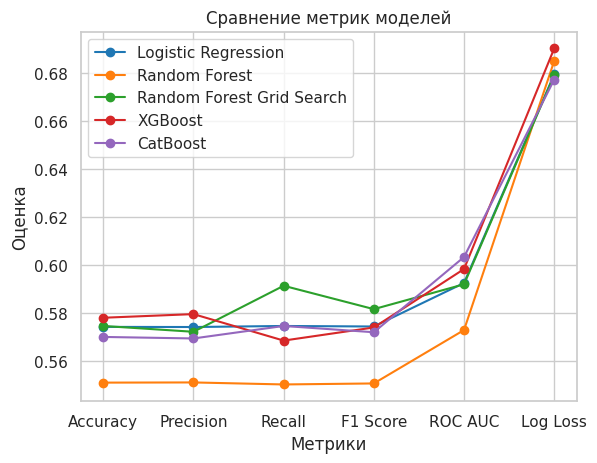

In [75]:
plt.plot(metrics, lr_metrics, marker="o", color=colors[0], label="Logistic Regression")
plt.plot(metrics, rf_metrics, marker="o", color=colors[1], label="Random Forest")
plt.plot(
    metrics, rf_best_metrics, marker="o", color=colors[2], label="Random Forest Grid Search"
)
plt.plot(metrics, xgb_metrics, marker="o", color=colors[3], label="XGBoost")
plt.plot(metrics, cat_metrics, marker="o", color=colors[4], label="CatBoost")

# Добавление легенды
plt.legend(loc="best")

# Добавление заголовка и меток осей
plt.title("Сравнение метрик моделей")
plt.xlabel("Метрики")
plt.ylabel("Оценка")

# Добавление сетки для удобства чтения
plt.grid(True)

# Отображение графика
plt.show()